In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

In [10]:
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

In [11]:
class EncoderDecoder(nn.Module):
    def __init__(self):
        super(EncoderDecoder, self).__init__()

        # Defining the encoding path
        self.enc_conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.enc_conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.activation = nn.ReLU()
        self.flatten = nn.Flatten()

        # Defining the decoding path
        self.unflatten = nn.Unflatten(1, (32, 7, 7))
        self.dec_conv1 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec_conv2 = nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.output_activation = nn.Sigmoid()

    def encode(self, x):
        x = self.activation(self.enc_conv1(x))
        x = self.activation(self.enc_conv2(x))
        x = self.flatten(x)
        return x

    def decode(self, x):
        x = self.unflatten(x)
        x = self.activation(self.dec_conv1(x))
        x = self.output_activation(self.dec_conv2(x))
        return x

    def forward(self, x):
        encoded = self.encode(x)
        decoded = self.decode(encoded)
        return encoded, decoded

# Initialization of the model
autoencoder = EncoderDecoder()

In [12]:
loss_function = nn.MSELoss()
adam_optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

epochs = 10
for current_epoch in range(epochs):
    epoch_loss = 0.0

    for batch in trainloader:
        inputs, _ = batch

        adam_optimizer.zero_grad()

        encodings, reconstructions = autoencoder(inputs)

        batch_loss = loss_function(reconstructions, inputs)

        batch_loss.backward()

        adam_optimizer.step()

        epoch_loss += batch_loss.item()

    # Display average loss for this epoch
    average_loss = epoch_loss / len(trainloader)
    print(f"Epoch {current_epoch + 1}/{epochs}, Average Loss: {average_loss:.4f}")

print("Training Completed")

Epoch 1/10, Average Loss: 0.0151
Epoch 2/10, Average Loss: 0.0020
Epoch 3/10, Average Loss: 0.0014
Epoch 4/10, Average Loss: 0.0011
Epoch 5/10, Average Loss: 0.0009
Epoch 6/10, Average Loss: 0.0008
Epoch 7/10, Average Loss: 0.0007
Epoch 8/10, Average Loss: 0.0006
Epoch 9/10, Average Loss: 0.0006
Epoch 10/10, Average Loss: 0.0006
Training Completed


In [13]:
compressed_representations = []

with torch.no_grad():
    for batch_data in trainloader:
        input_images, _ = batch_data

        latent_vectors, _ = autoencoder(input_images)

        compressed_representations.append(latent_vectors.cpu().numpy())

compressed_representations = torch.tensor(np.concatenate(compressed_representations, axis=0))

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


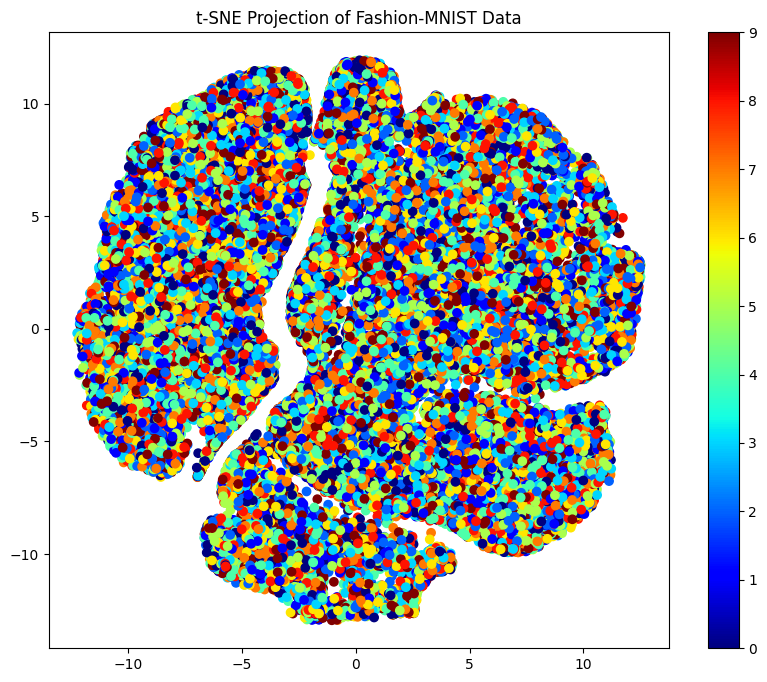

In [14]:
from sklearn.manifold import TSNE

# Initializing t-SNE with different parameters
tsne_model = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)

# Fitting and transforming the lower-dimensional representations
tsne_results_2d = tsne_model.fit_transform(compressed_representations)

# Plotting the t-SNE results
plt.figure(figsize=(10, 8))
scatter_plot = plt.scatter(tsne_results_2d[:, 0], tsne_results_2d[:, 1],
                           c=trainset.targets, cmap='jet')

plt.colorbar(scatter_plot)
plt.title("t-SNE Projection of Fashion-MNIST Data")
plt.show()